## Entanglement (Intrication) — the idea before the exercise

### 1) What is **entanglement**?
Entanglement happens when **two qubits share one single joint state**, and we **cannot describe them separately**.

- If two qubits are *not* entangled, their total state can be separated like this:

$$
\boxed{\,|\psi\rangle = |\psi_1\rangle \otimes |\psi_2\rangle\,}
$$

- If they **are** entangled, this is **not possible**:
> We cannot write the state as “state of qubit A” × “state of qubit B”.  
> The information is in the **pair**, not in each qubit alone.

This is the key message:  
✅ **Entangled states cannot be separated into independent single-qubit states.**

---

### 2) Superposition vs Entanglement (clear difference)

#### A) **Superposition** (one qubit)
Superposition is about **one qubit** being in a combination of $|0\rangle$ and $|1\rangle$:

$$
\boxed{\,|\psi\rangle = \alpha|0\rangle + \beta|1\rangle\,}
$$

When we measure, we get:
- 0 with probability $|\alpha|^2$
- 1 with probability $|\beta|^2$

So superposition means: **one qubit has multiple possibilities until measurement**.

**Example (easy):** if we apply $H$ to $|0\rangle$, we get

$$
\boxed{\,|+\rangle = H|0\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}\,}
$$

If we measure $|+\rangle$, we expect:
- about 50% zeros
- about 50% ones

#### B) **Two qubits can also be in superposition without entanglement**
Example (two independent superpositions):

$$
\boxed{\,|+\rangle\otimes|+\rangle
= \frac{1}{2}\big(|00\rangle+|01\rangle+|10\rangle+|11\rangle\big)\,}
$$

This is a superposition of 4 outcomes, but it is **NOT entanglement** because it can still be written as a product state.

**What you observe when measuring:** the qubits behave like **two independent coin flips** (no strong correlation).

#### C) **Entanglement** (two or more qubits)
Entanglement is about **multiple qubits** being linked so the system must be described together.

Example (Bell state):

$$
\boxed{\,|\Phi^+\rangle=\frac{|00\rangle+|11\rangle}{\sqrt{2}}\,}
$$

Meaning:
- each measurement is random,
- but the results are **linked (correlated)**:
  - we mostly see **00** and **11** (in an ideal simulator),
  - and almost never see **01** or **10**.

So:
- **Superposition** = “one system has multiple possibilities”
- **Entanglement** = “many qubits share one state; outcomes are linked”

---

### 3) The 4 Bell states (the entangled “alphabet”)
There are four maximally entangled Bell states:

$$
\boxed{
|\Phi^+\rangle=\frac{|00\rangle+|11\rangle}{\sqrt{2}}, \qquad
|\Phi^-\rangle=\frac{|00\rangle-|11\rangle}{\sqrt{2}}
}
$$

$$
\boxed{
|\Psi^+\rangle=\frac{|01\rangle+|10\rangle}{\sqrt{2}}, \qquad
|\Psi^-\rangle=\frac{|01\rangle-|10\rangle}{\sqrt{2}}
}
$$

- **Φ states**: same bits (00 or 11)  
- **Ψ states**: different bits (01 or 10)  
- The **±** sign is a phase difference (important for decoding and interference steps)

#### Can we have only one Bell state at a time?
- For a **given pair** of qubits at one moment: yes, it is in **one specific state**.
- But we can have **many Bell pairs at the same time** if we have more qubits.  
  Example: with 4 qubits we can entangle (q0,q1) as one Bell pair and (q2,q3) as another Bell pair.

---

### 4) Why do we care? Real-life meaning (practical examples)
Entanglement is not just a “cool idea” — it is a **resource** used in real technologies and research:

✅ **Quantum teleportation (quantum networks)**
- Teleportation uses a **shared Bell pair** + **2 classical bits** to transfer an unknown qubit state from Alice to Bob.
- This is a building block for future **quantum networks / quantum internet**.

✅ **Superdense coding (communication efficiency)**
- Superdense coding uses the fact there are **4 Bell states**.
- Alice starts with $|\Phi^+\rangle$ and applies one of $I, X, Z, XZ$ to encode 2 classical bits:
  - 00 $\rightarrow I$
  - 01 $\rightarrow X$
  - 10 $\rightarrow Z$
  - 11 $\rightarrow XZ$
- After that, the pair becomes one of the 4 Bell states, and Bob decodes them back into bits.
So the “other Bell forms” are **literally the encoding alphabet**.

✅ **Quantum communication security (QKD idea)**
- Entanglement correlations can reveal eavesdropping: interference usually changes the correlations.
- This idea appears in entanglement-based Quantum Key Distribution (QKD).

✅ **Benchmarking real quantum hardware**
- Bell states are used to test if a quantum computer can create entanglement reliably.
- In real QPUs, you may see small errors (noise), so counts are not perfectly ideal.

---



### Exercise — Compare “non-entangled” vs “entangled” 2-qubit states

**Goal:** Build two different 2-qubit circuits and compare their measurement histograms.

We will do it in two steps:

1) **Non-entangled state:** create two qubits in independent superposition  
   (this is NOT entanglement — it is like two independent coin flips)

2) **Entangled state (Bell):** create a Bell pair  
   (this IS entanglement — the results are correlated)

For each case, we will:
- draw the circuit
- print the quantum state (statevector) *before measurement*
- measure and plot a histogram


In [61]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
from IPython.display import display
import matplotlib.pyplot as plt

sampler = StatevectorSampler()

def show_statevector(circuit_no_measure, label="Statevector"):
    """Print the statevector (works for small circuits)."""
    sv = Statevector.from_instruction(circuit_no_measure)
    print(f"\n--- {label} ---")
    print(sv.draw(output="text"))
  # prints amplitudes of |00>, |01>, |10>, |11>
    # return sv

def run_and_plot_counts(circuit_with_measure, shots=500, title="Histogram"):
    """Run on simulator and plot measurement counts."""
    result = sampler.run([circuit_with_measure], shots=shots).result()
    counts = result[0].data.meas.get_counts()
    print(f"\nCounts (shots={shots}):", counts)
    plot_histogram(counts, title=title)
    plt.show()
    return counts


## Part A — Two qubits in superposition (NOT entangled)

**Task:** Create two independent superpositions by applying **H on both qubits**.

Expected idea:
- This is a superposition over **four** outcomes: 00, 01, 10, 11
- The outcomes behave like **two independent coin flips**



--- Non-entangled: |+> ⊗ |+> ---
[0.5+0.j,0.5+0.j,0.5+0.j,0.5+0.j]
Statevector([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j],
            dims=(2, 2))


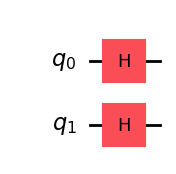

In [60]:
# Circuit WITHOUT measurement (so we can print the quantum state)
qc_sep_state = QuantumCircuit(2)

# Put each qubit into superposition (independent)
qc_sep_state.h(0)
qc_sep_state.h(1)

# Show the circuit
qc_sep_state.draw(output="mpl")

# Print the statevector (before measurement)
show_statevector(qc_sep_state, label="Non-entangled: |+> ⊗ |+>")



# fig = qc_sep_state.draw(output="mpl")
# display(fig) in case it show up twice in the notebook we can fix it by using display or as i did remove the desplay and only keep the draw 


Counts (shots=500): {'11': 125, '01': 118, '10': 134, '00': 123}


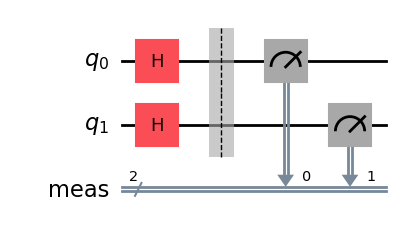

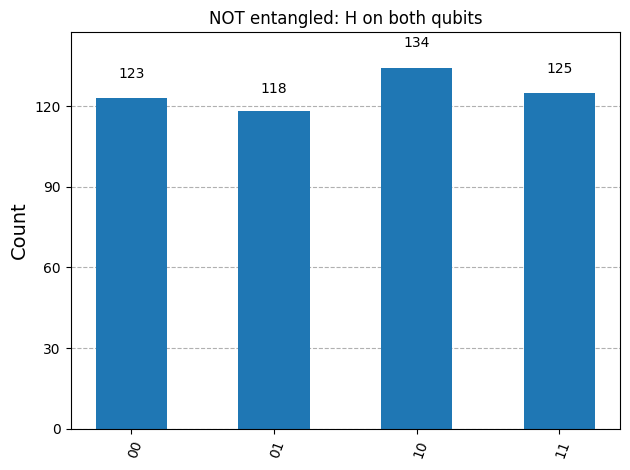

{'11': 125, '01': 118, '10': 134, '00': 123}

In [51]:
# Create a copy with measurement for histogram
qc_sep = QuantumCircuit(2)
qc_sep.h(0)
qc_sep.h(1)
qc_sep.measure_all()

qc_sep.draw(output="mpl")

# Histogram
run_and_plot_counts(qc_sep, shots=500, title="NOT entangled: H on both qubits")


### WHAT TO NOTICE (Part A)
- You should see counts spread across **00, 01, 10, 11**.
- No strong correlation: results look like **two independent coin flips**.


## Part B — Two qubits entangled (Bell state)

**Task:** Create a Bell pair using:
1) **H on qubit 0**
2) **CX(0, 1)**

Expected idea:
- The state becomes:
  $$|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$
- Measurement results are **correlated**: mostly 00 and 11



--- Entangled: Bell state |Φ+> ---
[0.70710678+0.j,0.        +0.j,0.        +0.j,0.70710678+0.j]


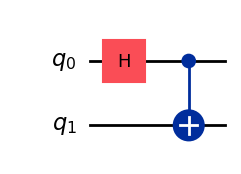

In [66]:
# Circuit WITHOUT measurement (so we can print the quantum state)
qc_bell_state = QuantumCircuit(2)

# Create Bell state
qc_bell_state.h(0)
qc_bell_state.cx(0, 1)

qc_bell_state.draw(output="mpl")

# Print the statevector (before measurement)
show_statevector(qc_bell_state, label="Entangled: Bell state |Φ+>")



Counts (shots=500): {'00': 238, '11': 262}


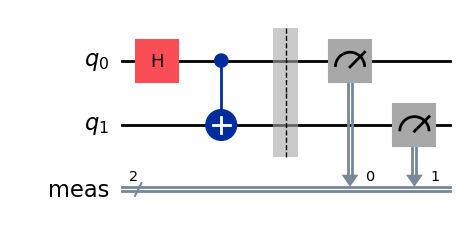

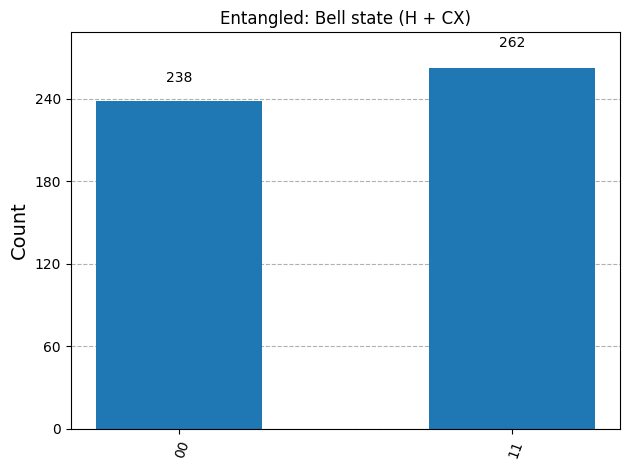

{'00': 238, '11': 262}

In [68]:
# Create a copy with measurement for histogram
qc_bell = QuantumCircuit(2)
qc_bell.h(0)
qc_bell.cx(0, 1)
qc_bell.measure_all()

qc_bell.draw(output="mpl")

# Histogram
run_and_plot_counts(qc_bell, shots=500, title="Entangled: Bell state (H + CX)")


### WHAT TO NOTICE (Part B)
- You should see mostly **00** and **11**.
- Each qubit alone looks random (50/50), but together they are **linked**:
  - if the first is 0, the second is 0
  - if the first is 1, the second is 1
This strong correlation is the sign of **entanglement**.


## Compare the two results

- **Part A (not entangled):** outcomes spread over **00, 01, 10, 11**
- **Part B (entangled Bell):** outcomes mainly **00 and 11**

✅ Same number of qubits, but very different behavior because the **joint state** is different.


### EXERCISE (students)
1) Increase shots to **2000** in both cases. What changes?
2) Try to create a different Bell state:
   - Add an **X** on qubit 1 *before measurement* and see what happens.
3) Challenge: Can you get mostly **01** and **10** instead of 00 and 11?


### What you should notice
Only 00 and 11 appear with high probability.


In [ ]:
# Bell state on simulator.
bell = QuantumCircuit(2, 2)
bell.h(0)
bell.cx(0, 1)
bell.measure([0, 1], [0, 1])
show_circuit(bell)
run_and_plot_counts(bell)


## EXERCISE
Compute the correlation rate: (00 + 11) / total.


In [ ]:
# Student solution cell (optional).


## GOAL
Superdense coding: send 2 classical bits using 1 qubit + entanglement.


### What you should notice
Each message decodes to a unique bitstring.

Encoding table:
- 00 -> I
- 01 -> X
- 10 -> Z
- 11 -> XZ


In [ ]:
# Superdense coding demo.
def superdense(msg):
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    if msg == "01":
        qc.x(0)
    elif msg == "10":
        qc.z(0)
    elif msg == "11":
        qc.x(0)
        qc.z(0)
    qc.cx(0, 1)
    qc.h(0)
    qc.measure([0, 1], [0, 1])
    return qc

for msg in ["00", "01", "10", "11"]:
    qc = superdense(msg)
    show_circuit(qc)
    run_and_plot_counts(qc)


## EXERCISE
Test all four messages and verify the decoded output.


In [ ]:
# Student solution cell (optional).
